In [1]:
from skimage import data, io, filters, restoration
from skimage.util import view_as_windows as viewW
from skimage.util import random_noise
from skimage.morphology import disk
from matplotlib import pyplot as plt
import cv2 as cv
import scipy
import numpy
import math
import os
import random
from deap import base, creator, tools, algorithms

In [2]:
def im2col_sliding_strided_v2(A, BSZ, stepsize=1):
    return viewW(A, (BSZ[0],BSZ[1])).reshape(-1,BSZ[0]*BSZ[1]).T[:,::stepsize]

def im2col_sliding_broadcasting(A, BSZ, stepsize=1):
    # Parameters
    M,N = A.shape
    col_extent = N - BSZ[1] + 1
    row_extent = M - BSZ[0] + 1

    # Get Starting block indices
    start_idx = numpy.arange(BSZ[0])[:,None]*N + numpy.arange(BSZ[1])

    # Get offsetted indices across the height and width of input array
    offset_idx = numpy.arange(row_extent)[:,None]*N + numpy.arange(col_extent)

    # Get all actual indices & index into input array for final output
    return numpy.take (A,start_idx.ravel()[:,None] + offset_idx.ravel()[::stepsize])


## Resources

- Source code: https://uk.mathworks.com/matlabcentral/fileexchange/36921-noise-level-estimation-from-a-single-image
- MATLAB to python: https://cheatsheets.quantecon.org/, http://mathesaurus.sourceforge.net/matlab-numpy.html



In [3]:
"""
Output params:
nlevel: estimated noise level
th: threshold to extract weak texture patches at the last iteration
num: number of extracted weak texture patches

Input Params:
img: intput single image
patchsize (optional): patch size(default: 7)
decim (optional): decimation factor. Large number = accelerated calculation 
                  (default: 0)
conf (optional): confidence interval to determin the treshold for the 
                 weak texture. usually very close to one (default: 0.99)
itr (optional): number of iterations (default: 3)
"""

def NoiseLevel(img, patchsize = 7, decim = 0, conf = None, itr = 3):
    img = img.astype(numpy.float32)
    if not conf:
        conf = 1-1e-6
    kh = numpy.array([[[-1/2],[0],[1/2]]])
    imgh = scipy.ndimage.correlate(img, kh, mode="nearest")
    imgh = imgh[:,1:len(imgh[1])-1,:]
    imgh = numpy.multiply(imgh, imgh)
    
    kv = numpy.array([[[-1/2]],[[0]],[[1/2]]])
    imgv = scipy.ndimage.correlate(img, kv, mode="nearest")
    imgv = imgv[1:len(imgv)-1,:,:]
    imgv = numpy.multiply(imgv, imgv)
    
    
    Dh = my_convmtx(kh, patchsize, patchsize)
    Dv = my_convmtx(kv, patchsize, patchsize)
    DD = Dh.conj().transpose().dot(Dh)\
         +Dv.conj().transpose().dot(Dv)
    r = numpy.linalg.matrix_rank(DD)
    Dtr = DD.trace(offset=0);
    tau0 = scipy.stats.gamma.ppf(conf,float(r)/2, scale = 2.0 * Dtr / float(r));
    
    nlevel = []
    th = []
    num = []
    for cha in range(img.shape[2]):
        X = im2col_sliding_broadcasting(img[:,:,cha],(patchsize, patchsize))
        Xh = im2col_sliding_broadcasting(imgh[:,:,cha],(patchsize, patchsize-2))
        Xv = im2col_sliding_broadcasting(imgv[:,:,cha],(patchsize-2, patchsize))

        Xtr = numpy.vstack((Xh,Xv)).sum(axis=0)
        if decim > 0:
            XtrX = numpy.vstack((Xtr,X));
            XtrX = sortrows(XtrX.conj().transpose())
            p = math.floor(XtrX.shape[1]/(decim+1))
            p = numpy.array(range(0,p)) * (decim+1)
            Xtr = XtrX[1].take(p, axis=1)
            X = XtrX[2:size(XtrX,1)].take(p, axis=1)
        # Noise level estimation
        tau = math.inf
        if X.shape[1] < X.shape[0]:
            sig2 = 0
        else:
            cov = X.dot((X.conj().T))/(X.shape[1]-1)
            d = numpy.linalg.eigvals(cov)
            d.sort()
            sig2 = d[0]
        for i in range(2,itr+1):
            # weak texture selection
            tau = sig2 * tau0
            #p = [1 if pp < tau else 0 for pp in Xtr]
            p = Xtr<tau
            Xtr = Xtr[p]
            X = X[:,p==1]
            
            # noise level estimation
            if X.shape[1] < X.shape[0]:
                break

            cov = X.dot((X.conj().T))/(X.shape[1]-1)
            d = numpy.linalg.eigvals(cov)
            d.sort()
            sig2 = d[0]
        nlevel.append(math.sqrt(sig2))
        th.append(tau)
        num.append(X.shape[1])
    
    return nlevel, th, num
            
            
        

In [4]:
def my_convmtx(H, m, n):
    s = H.shape
    T = numpy.zeros((((m-s[0]+1)*(n-s[1]+1)), (m*n)), float)
    k = 0
    for i in range(1,(m-s[0]+2)):
        for j in range(1,(n-s[1]+2)):
            for p in range(1,s[0]+1):
                h_index = p-1
                for x in range((i-1+p-1)*n+(j-1),(i-1+p-1)*n+(j-1)+s[1]):
                    T[k,x] = H.flatten()[h_index]
                    h_index += 1
            k += 1
    return T
    
        

In [5]:
"""
Output parameters:
msk: weak texture mask. 0 and 1 represent non-weak-texture and weak-texture
     respectively

Input Parameters:
img: input single image
th: threshold which is output of NoiseLevel
patchsize (optional): patchsize (default: 7)
"""
def weak_texture_mask(img, th, patchsize=7):
    img = img.astype(numpy.float32) #*(1/255))

    kh = numpy.array([[[-1/2],[0],[1/2]]])
    imgh = scipy.ndimage.correlate(img.astype(numpy.float32), kh, mode="nearest")
    imgh = imgh[:,1:len(imgh[1])-1,:]
    imgh = numpy.multiply(imgh, imgh)
    
    kv = numpy.array([[[-1/2]],[[0]],[[1/2]]])
    imgv = scipy.ndimage.correlate(img.astype(numpy.float32), kv, mode="nearest")
    imgv = imgv[1:len(imgv)-1,:,:]
    imgv = numpy.multiply(imgv, imgv)
    
    
    s = img.shape
    msk = numpy.zeros(s, float)
    
    for cha in range(0,s[2]):
        Xh = im2col_sliding_broadcasting(imgh[:,:,cha],(patchsize, patchsize-2))
        Xv = im2col_sliding_broadcasting(imgv[:,:,cha],(patchsize-2, patchsize))

        Xtr = numpy.vstack((Xh,Xv)).sum(axis=0)
        
        p = [pp < th[cha] for pp in Xtr]
        ind = 0
        for col in range(s[0]-patchsize+1):
            for row in range(s[1]-patchsize+1):
                if p[ind]:
                    msk[col:col+patchsize,row:row+patchsize, cha] = 1
                ind += 1
    return msk

    

In [6]:
test_image = cv.imread('images/42078.jpg')
test_image = test_image[:,:,::-1]


In [7]:
def add_gaussian_noise(img, sig = 1):
    m = (0,0,0) 
    s = (sig,sig,sig)  
    noise = numpy.zeros(img.shape)
    cv.randn(noise,m,s)
    print(noise.min(), noise.max())
    new_img = (img+noise) 
    #new_img = (new_img - new_img.min()) * (255/new_img.max())
    return new_img

[0.2531898221267512, 0.25197274940481923, 0.2911626569078624] [9.234120865679499, 8.96987145541392, 10.42811114533607] [64928, 68376, 73757]


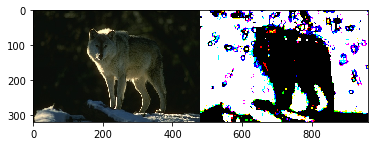

-4.8281474113464355 4.650505542755127
[1.0078973456873201, 1.007548921977599, 1.027651170724491] [87.43949877716894, 87.3039418884239, 90.18277499224165] [66396, 68907, 74032]


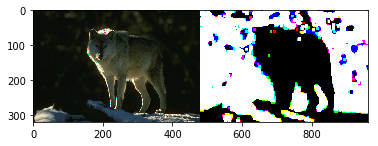

In [8]:
nlevel, th, num = NoiseLevel(test_image,4)
print(nlevel, th, num)
msk1 = weak_texture_mask(test_image, th, 4 )
disp1 = numpy.hstack((test_image,msk1.astype(numpy.uint8) * 255))
plt.imshow(disp1)
plt.show()

noisy_image = add_gaussian_noise(test_image)
nlevel, th, num = NoiseLevel(noisy_image)
print(nlevel, th, num)
msk2 = weak_texture_mask(noisy_image, th )
disp2 = numpy.hstack((noisy_image.astype(numpy.uint8),msk2.astype(numpy.uint8) * 255))
plt.imshow(disp2)
plt.show()

-5.101912975311279 4.361196994781494
Fitness when applying no denoising algorithm:  18996774
-------------
Fitness after applying denoising algorithm:  52488253


/home/sam/.local/lib/python3.6/site-packages/skimage/filters/_gaussian.py:108: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


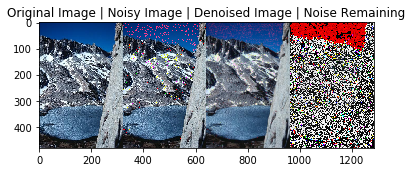


Testing fitness funtion with optional display parameter:


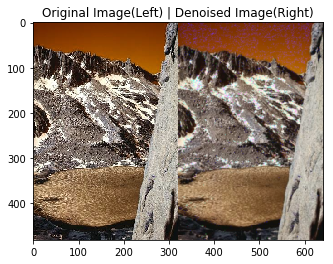

Result:  15.17125999205633


In [9]:
import importlib
from util import performance_functions
importlib.reload(performance_functions)

def evaluate_fitness(denoised_image, original_image, display_images=False):
    
    if display_images:
        
        merged_images = numpy.hstack((original_image,denoised_image))
        plt.title("Original Image(Left) | Denoised Image(Right)")
        plt.imshow(merged_images)
        plt.show()
        
    return performance_functions.root_mean_squared_error(denoised_image, original_image)

fitness_test_image = cv.imread('images/167083.jpg')

noisy_test_images = fitness_test_image.copy()

noisy_test_images = add_gaussian_noise(noisy_test_images).astype(numpy.uint8)

denoised_test_image = filters.gaussian(noisy_test_images,sigma=1)
denoised_test_image *= 255
denoised_test_image = denoised_test_image.astype(numpy.uint8)

baseline = fitness_test_image - noisy_test_images

test_fitness = fitness_test_image - denoised_test_image

print("Fitness when applying no denoising algorithm: ",numpy.absolute(baseline).sum())
print("-------------")
print("Fitness after applying denoising algorithm: ", numpy.absolute(test_fitness).sum())

all_images_merged = numpy.hstack((fitness_test_image,noisy_test_images,denoised_test_image,test_fitness))
rgb_all_images = cv.cvtColor(all_images_merged, cv.COLOR_BGR2RGB)
plt.imshow(rgb_all_images)
plt.title("Original Image | Noisy Image | Denoised Image | Noise Remaining")
plt.show()

print("\nTesting fitness funtion with optional display parameter:")
print("Result: ", evaluate_fitness(denoised_test_image, fitness_test_image, display_images=True))

In [10]:
import sys
class ImageDataset:
    
    def __init__(self, size):
        self.dir_location = "images/"
        self.base_images = []
        self.noisy_images = []
        self.weak_texture_masks = []
        self.noise_levels = []
        self.load_files(size)
        
        
    def load_files(self, size):
        self.base_images = []
        for image_name in os.listdir(self.dir_location):
            if len(self.base_images) >= size:
                break
            new_image = cv.imread(self.dir_location+image_name);
            new_image = new_image[:,:,::-1]
            self.base_images += [new_image]
            noisy_image = random_noise(new_image, mode="gaussian", var=0.005)
            
            self.noisy_images += [noisy_image]
            try:
                nlevel, th, num = NoiseLevel(noisy_image,7)
                self.noise_levels += [nlevel]
                new_image_mask = weak_texture_mask(noisy_image,th,7)
                self.weak_texture_masks += [new_image_mask]
            except Exception as e:
                print(e)
                plt.imshow(new_image)
                plt.show()
            
            
            
        

In [35]:
images = ImageDataset(2)

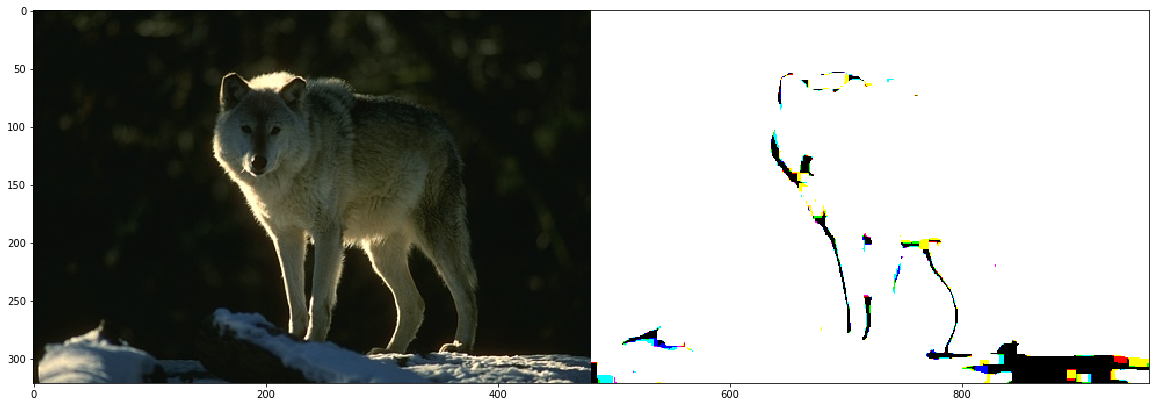

In [43]:
img_and_mask = numpy.hstack((images.base_images[1],images.weak_texture_masks[1]*255)).astype(numpy.uint8)
plt.imshow(img_and_mask)
plt.show()

## Sensors

| Sensor ID | Sensor Data |
| --- | --- |
| 0 | weak texture mask |
| 1 | non weak texture mask |

## Actions

| Action ID | Action |
| --- | --- |
| 0 | gaussian_filter_coins sigma 1 | 
| 1 | gaussian_filter_coins sigma 2 |
| 2 | median_filter one(3, 3) |
| 3 | tv_chambolle weight 0.1 |

In [48]:
def denoise_image(image, action_id):
    
    psf = numpy.ones((5, 5, 3)) / 25
    actions = [
        lambda x : (filters.gaussian(x ,sigma=0.6)*255).astype(numpy.uint8),
        lambda x : (filters.gaussian(x, sigma=2)*255).astype(numpy.uint8),
        lambda x : (filters.gaussian(x, sigma=4)*255).astype(numpy.uint8),
        lambda x : (filters.gaussian(x, sigma=8)*255).astype(numpy.uint8),
        lambda x : (restoration.denoise_tv_chambolle(x, weight=0.1)*255).astype(numpy.uint8),
        lambda x : (restoration.denoise_tv_chambolle(x, weight=0.05)*255).astype(numpy.uint8),
        lambda x : (restoration.denoise_tv_chambolle(x, weight=0.0025)*255).astype(numpy.uint8),
        lambda x : (restoration.denoise_tv_chambolle(x, weight=0.01)*255).astype(numpy.uint8),
    ]
    if action_id > len(actions):
        return image
    return actions[action_id](image)

In [38]:
def bits_to_int(bit_list):
    return sum([(x*(2**i)) for i, x in enumerate(bit_list[::-1])])

In [39]:
def extract_weak_texture(image, weak_texture_mask):
    weak_texture = (image * weak_texture_mask).astype(numpy.uint8)
    strong_texture = image - weak_texture
    return strong_texture.astype(numpy.uint8), weak_texture.astype(numpy.uint8)

In [40]:
def excecute_actions(individual, image_index = 0):
    weak_texture_action = bits_to_int(individual[0:len(individual)//2])
    strong_texture_action = bits_to_int(individual[len(individual)//2:len(individual)])
    
    
    denoised_weak_texture = denoise_image(images.noisy_images[image_index], weak_texture_action)
    denoised_strong_texture = denoise_image(images.noisy_images[image_index], strong_texture_action)
    
    strong_texture, _ = extract_weak_texture(denoised_strong_texture, images.weak_texture_masks[image_index])
    _, weak_texture = extract_weak_texture(denoised_weak_texture, images.weak_texture_masks[image_index])
    
    return (strong_texture + weak_texture ) 
    

In [74]:
import importlib
from util import performance_functions
importlib.reload(performance_functions)

def evaluate(individual, display=False, image_index = 0): 
    
    denoised_image = excecute_actions(individual, image_index)
    
    if display:
        print("PSNR: %f\n IQI: %f\n SSIM: %f\n" % \
              (performance_functions.peak_signal_noise_ration(images.base_images[image_index], denoised_image),\
               performance_functions.image_quality_index(images.base_images[image_index], denoised_image),\
               performance_functions.structural_similarity_indix(images.base_images[image_index], denoised_image),))
        plt.rcParams["figure.figsize"]=20,20
        merged_images = numpy.hstack((images.base_images[image_index],\
                                      images.noisy_images[image_index]*255,\
                                      denoised_image))\
                             .astype(numpy.uint8)
        plt.title("Original Image(Left) | Noisy Image(Center) | Denoised Image(Right)")
        plt.imshow(merged_images)
        plt.show()
        
                                                   
                                                   
    return performance_functions.root_mean_squared_error(denoised_image, images.base_images[image_index]),
    
    

/home/sam/.local/lib/python3.6/site-packages/skimage/filters/_gaussian.py:108: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


PSNR: 22.960867
 IQI: 0.996238
 SSIM: 0.788719



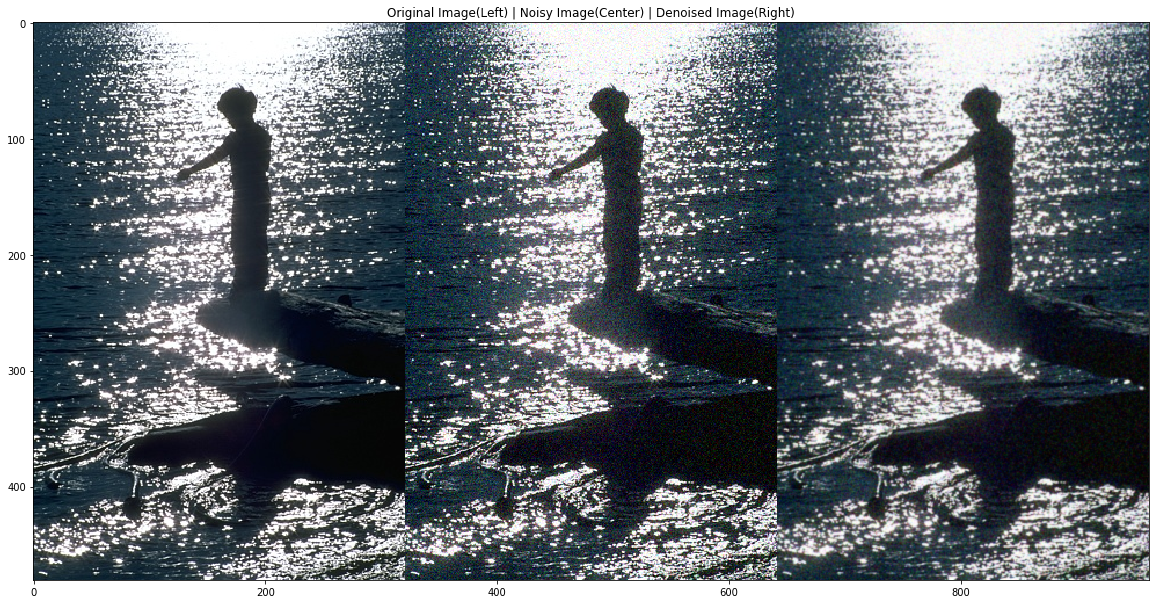

(14.789788098849153,)

In [75]:
evaluate([0,0,0,0,0,0], True)

/home/sam/.local/lib/python3.6/site-packages/skimage/filters/_gaussian.py:108: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


[1, 0, 1, 1, 1, 0]


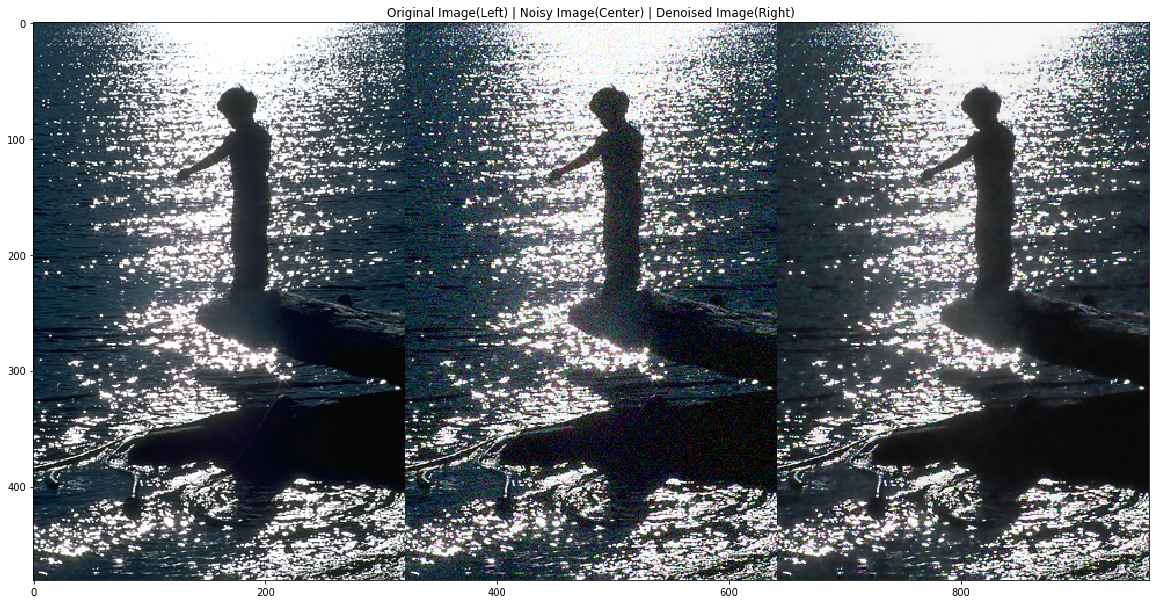

(14.087004943072113,)


In [18]:
import random
from deap import algorithms, base, creator, tools

NUM_FILTERS = 8
SIZE_OF_INDIVIDUAL = math.ceil(math.log2(NUM_FILTERS**2))

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)


toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=SIZE_OF_INDIVIDUAL)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)


pop = toolbox.population(n=20)
algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=20, verbose=False)
print(tools.selBest(pop, k=1)[0])
print(evaluate(tools.selBest(pop, k=1)[0], True))

In [65]:
def compare_results(individual):
    test_image_rmse = evaluate(individual, True)
    new_image_rmse = evaluate(individual, True, 1)
    print("Test Image RMSE: %f \nUnseen Image RMSE: %f"%(test_image_rmse[0], new_image_rmse[0]))
    print("Test Image Estimated Noise:", images.noise_levels[0])
    print("Unseen Image Estimated Noise:", images.noise_levels[1])

PSNR: 25.804726
 IQI: 0.998072
 SSIM: 0.877936



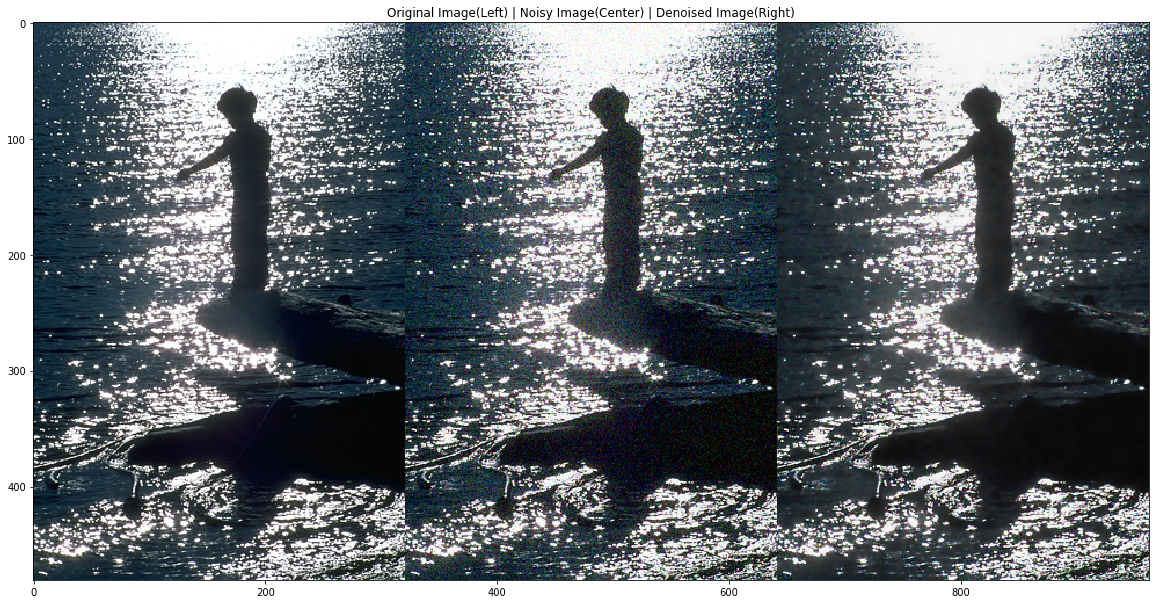

PSNR: 31.626962
 IQI: 0.994452
 SSIM: 0.900698



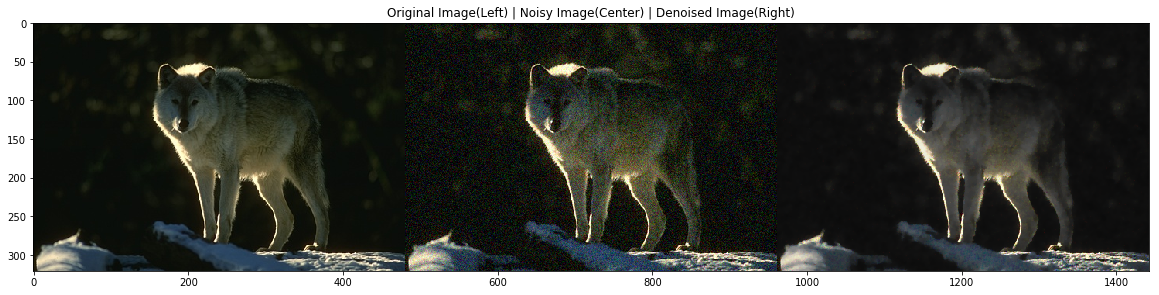

Test Image RMSE: 14.122471 
Unseen Image RMSE: 9.692601
Test Image Estimated Noise: [0.058681503783923644, 0.06254540224840556, 0.06444977621568822]
Unseen Image Estimated Noise: [0.05931177387471849, 0.061958009422549316, 0.05606591945539029]


In [76]:
compare_results(tools.selBest(pop, k=1)[0])